In [1]:
from sim_data import *
import numpy as np

# set seed for reproducibility
np.random.seed(100)

# iIRF parameters
rep_rate = 40
k = 512
fwhm = 0.2

# iIRF only needs to be generated once
# it is measured one time and the sa
# me for all signals
iirf, t = gaussian_irf(rep_rate, k, fwhm)

nonZeroIdx = np.argmin(np.abs(iirf[:int(len(iirf)/2)] - 1/20))
iirf_aligned = 0.5 * np.roll(iirf, -nonZeroIdx)

# number of sets to generate
N = 1000



In [2]:
# fractional contributions and taus randomly generated
# in this case, based on the information in the paper,
# fractional contributions are generated from a uniform distribution between 
# 0 and 100%
# and taus are randomly generated from a uniform distribution between 1 and 6 ns
# and the number of exponential components generated is randomly picked from 1-6
rng = np.random.default_rng(100)
M = rng.integers(low=1, high=6, size=N)
# TODO order fracs and taus correctly for input into gen_signal
parts = [rng.random(m) for m in M]
fracs = [parts[n] / sum(parts[n]) for n in range(N)]
taus = [rng.uniform(low = 1, high = 6, size = m) for m in M]





In [3]:
decays = []
avg_taus = []
for n in range(N):
    decay, t, avg_lts = gen_signal(rep_rate, k, fracs[n], taus[n], iirf)
    noisy_decay = add_white_noise(decay, 20)
    decays.append(noisy_decay)
    avg_taus.append(avg_lts)

In [4]:
import matplotlib.pyplot as plt

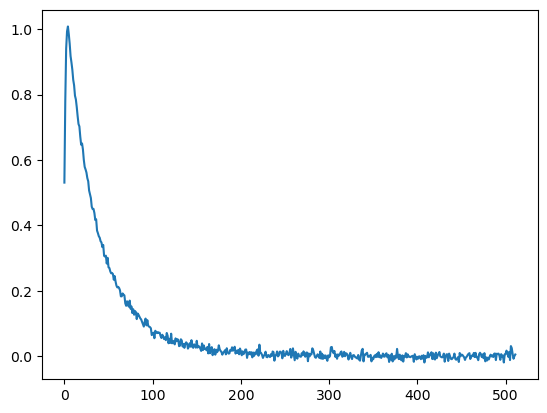

In [140]:

plt.plot(decays[0])

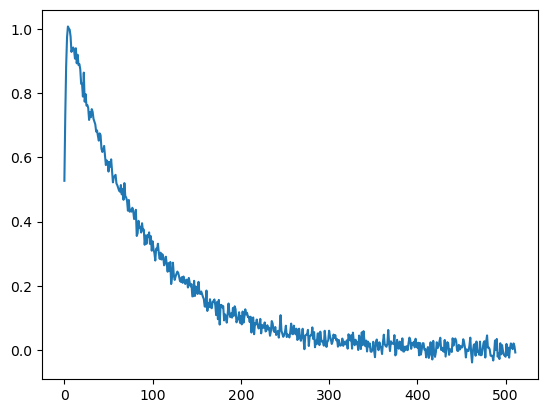

In [141]:
plt.plot(decays[800])

In [5]:
from compute_V import *
from laguerre_basis import *
from compute_tau import * 

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

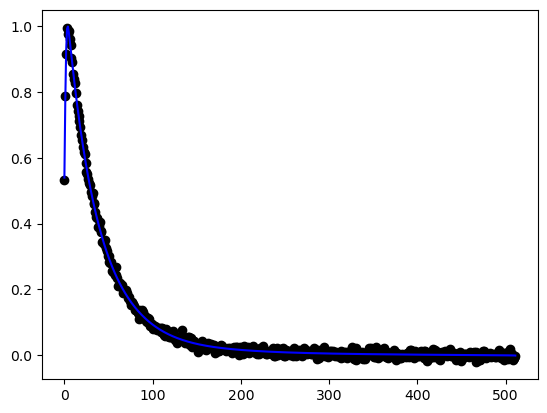

In [184]:
i = 500
plt.plot(np.arange(k), reg_pred[i], color = 'blue')
plt.scatter(np.arange(k), decays[i], color = 'black')

In [7]:
from golden_search_alg import *

In [12]:
def do_predictions(k, alpha, L, dt, iirf, datasets):
    V = compute_V(k, alpha, L, iirf)
    B = basis_array(k, alpha, L)
    regr = linear_model.LinearRegression()
    pred_taus = []
    for d in datasets:
        regr.fit(V,d)
        taus = compute_tau_avg(regr.coef_, dt, B, k) * 1e9
        pred_taus.append(taus)

    return pred_taus

In [8]:
test_data = decays[800:]
train_data = decays[:800]
test_taus = avg_taus[800:]
train_taus = avg_taus[:800]
dt = t[1]
k = 512

In [32]:
def golden_search(L, dt, iirf, datasets, tau, k, n_iter = 1):
    tolerance = 1e-5
    lower_limit = 0
    upper_limit = 1
    alpha = upper_limit + lower_limit /2

    invphi = (math.sqrt(5) - 1) / 2  # 1 / phi

    train_data = datasets[:640]
    train_taus = tau[:640]
    val_data = datasets[640:]
    val_taus = tau[640:]

    loss = []
    val_loss = []
    for n in range(n_iter):
        alpha = (upper_limit + lower_limit) /2
        # record mse with test data
        tau_alpha = do_predictions(k=k, alpha=alpha, L=L, dt=dt, iirf=iirf, datasets=train_data)
        loss.append(mean_squared_error(train_taus, tau_alpha))
        # record loss with validation data
        val_tau_alpha = do_predictions(k=k, alpha=alpha, L=L, dt=dt, iirf=iirf, datasets=val_data)
        val_loss.append(mean_squared_error(val_taus, val_tau_alpha))

        # next iteration
        c = upper_limit - (upper_limit-lower_limit) * invphi

        d = lower_limit + (upper_limit-lower_limit) * invphi
        

        tau_c = do_predictions(k=k, alpha =c, L=L, dt=dt, iirf=iirf, datasets=train_data)
        tau_d = do_predictions(k=k, alpha = d, L=L, dt=dt, iirf=iirf, datasets=train_data)

        # update parameters
        if mean_squared_error(train_taus, tau_c) < mean_squared_error(train_taus, tau_d):
            upper_limit = d
        else:
            lower_limit = c
        

    return loss, val_loss,  alpha

In [58]:
n_iter = 15
loss_4, val_loss_4, alpha_4 = golden_search(4, dt, iirf, train_data, train_taus, k,15)
print(alpha_4)

0.9599400268659043


In [59]:
loss_8, val_loss_8, alpha_8 = golden_search(8, dt, iirf, train_data, train_taus, k,15)
print(alpha_8)

0.9336287918730547


In [61]:
loss_12, val_loss_12, alpha_12 = golden_search(12, dt, iirf, train_data, train_taus, k,15)
print(alpha_12)

0.9003731794140639


Text(0.5, 1.0, 'L=12\n alpha = 0.9004')

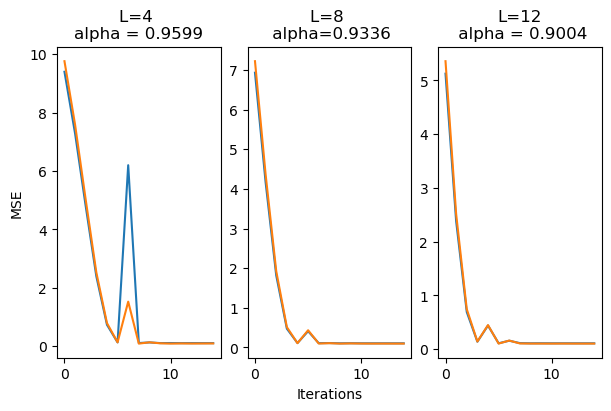

In [69]:
fig, ax = plt.subplots(1,3, figsize = (6,4), layout = 'constrained')
ax[0].plot(np.arange(n_iter), loss_4)
ax[0].plot(np.arange(n_iter), val_loss_4)
ax[1].plot(np.arange(n_iter), loss_8)
ax[1].plot(np.arange(n_iter), val_loss_8)
ax[2].plot(np.arange(n_iter), loss_12)
ax[2].plot(np.arange(n_iter), val_loss_12)
ax[0].set_ylabel('MSE')
ax[1].set_xlabel('Iterations')
ax[0].set_title(f'L=4 \nalpha = {round(alpha_4, 4)}')
ax[1].set_title(f'L=8 \n alpha={round(alpha_8, 4)}')
ax[2].set_title(f'L=12\n alpha = {round(alpha_12, 4)}')


In [72]:
alpha = 0.9599
L = 4
dt = t[1]
B = basis_array(k, alpha, L)
V = compute_V(k, alpha, L, iirf)
regr = linear_model.LinearRegression()
reg_pred = []
reg_coefs = []
reg_pred_taus_4 = []
inv_pred = []
inv_coefs = []
inv_pred_taus = []
for i in test_data:
    regr.fit(V, i)
    reg_pred.append(regr.predict(V))
    reg_coefs.append(regr.coef_)
    reg_pred_taus_4.append(compute_tau_avg(regr.coef_, dt, B, k) * 1e9)
    chat = np.linalg.inv(np.transpose(V) @ V) @ np.transpose(V) @ i
    inv_coefs.append(chat)
    inv_pred.append( V @ chat)
    inv_pred_taus.append(compute_tau_avg(chat, dt, B, k) * 1e9)

In [74]:
alpha = 0.9336
L = 8
dt = t[1]
B = basis_array(k, alpha, L)
V = compute_V(k, alpha, L, iirf)
regr = linear_model.LinearRegression()
reg_pred = []
reg_coefs = []
reg_pred_taus_8 = []
inv_pred = []
inv_coefs = []
inv_pred_taus = []
for i in test_data:
    regr.fit(V, i)
    reg_pred.append(regr.predict(V))
    reg_coefs.append(regr.coef_)
    reg_pred_taus_8.append(compute_tau_avg(regr.coef_, dt, B, k) * 1e9)
    chat = np.linalg.inv(np.transpose(V) @ V) @ np.transpose(V) @ i
    inv_coefs.append(chat)
    inv_pred.append( V @ chat)
    inv_pred_taus.append(compute_tau_avg(chat, dt, B, k) * 1e9)

In [75]:
alpha = 0.9003
L = 12
dt = t[1]
B = basis_array(k, alpha, L)
V = compute_V(k, alpha, L, iirf)
regr = linear_model.LinearRegression()
reg_pred = []
reg_coefs = []
reg_pred_taus_12 = []
inv_pred = []
inv_coefs = []
inv_pred_taus = []
for i in test_data:
    regr.fit(V, i)
    reg_pred.append(regr.predict(V))
    reg_coefs.append(regr.coef_)
    reg_pred_taus_12.append(compute_tau_avg(regr.coef_, dt, B, k) * 1e9)
    chat = np.linalg.inv(np.transpose(V) @ V) @ np.transpose(V) @ i
    inv_coefs.append(chat)
    inv_pred.append( V @ chat)
    inv_pred_taus.append(compute_tau_avg(chat, dt, B, k) * 1e9)

Text(0.5, 1.0, 'L=12\n alpha = 0.9004\nMSE=0.1088')

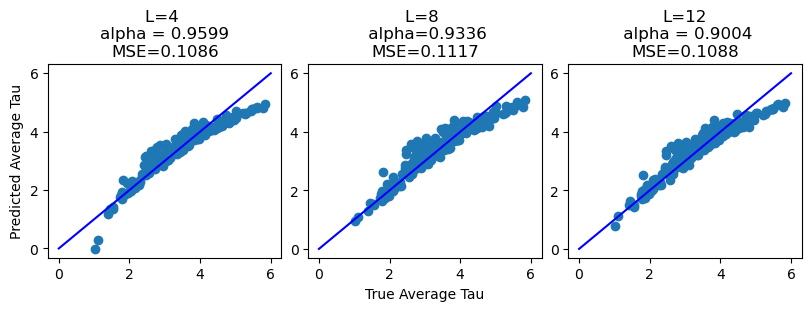

In [87]:
fig, ax = plt.subplots(1,3, figsize = (8,3), layout = 'constrained')
ax[0].scatter(test_taus, reg_pred_taus_4)
ax[0].plot(np.arange(0,7), np.arange(0,7), 'b')
ax[1].scatter(test_taus, reg_pred_taus_8)
ax[1].plot(np.arange(0,7), np.arange(0,7), 'b')
ax[2].scatter(test_taus, reg_pred_taus_12)
ax[2].plot(np.arange(0,7), np.arange(0,7), 'b')
ax[0].set_ylabel('Predicted Average Tau')
ax[1].set_xlabel('True Average Tau')
ax[0].set_title(f'L=4 \nalpha = {round(alpha_4, 4)}\nMSE={round(mean_squared_error(test_taus, reg_pred_taus_4),4)}')
ax[1].set_title(f'L=8 \n alpha={round(alpha_8, 4)}\nMSE={round(mean_squared_error(test_taus, reg_pred_taus_8),4)}')
ax[2].set_title(f'L=12\n alpha = {round(alpha_12, 4)}\nMSE={round(mean_squared_error(test_taus, reg_pred_taus_12),4)}')